# COVID-19 Vaccination Twitter Clustering

> 👩🏻‍💻 Shengchen Zhang <br>
> ✉️ shengchenzhang1207@gmail.com <br>
> 🏠 College of Design and Innovarion, Tongji University <br>
> 📍 Shanghai, China

Create semantically-meaningful clusters from Twitter discourse on COVID-19 vaccination. The method we use is informed by [BERTopic](https://github.com/MaartenGr/BERTopic) and [this blog post](https://www.atoti.io/topic-modeling-on-twitter-using-sentence-bert/), modified to fit our purpose.

The steps we take are as follows:
1. Create dense vector embeddings from the original tweet texts.
2. Perform dimensionality reduction on the vectors
3. Cluster the reduced vectors.
4. Filter outliers and merge clusters to arrive at desired number of clusters.

## Step 1: Embed the tweets

Create embedding vectors for the tweets using [SentenceTransformer](https://www.sbert.net/index.html), a transformer-based library that creates dence vector embedding for sentences.

In [1]:
from pybtex.database import parse_file
from sentence_transformers import SentenceTransformer, util

### 1. Create SentenceTransformer model

According to the SentenceTransformer team, `paraphrase-mpnet-base-v2` is the best performing model. But it might be slower to run.

In [2]:
model = SentenceTransformer('paraphrase-mpnet-base-v2')

Downloading: 100%|██████████| 190/190 [00:00<00:00, 222kB/s]
Downloading: 100%|██████████| 3.70k/3.70k [00:00<00:00, 3.99MB/s]
Downloading: 100%|██████████| 229/229 [00:00<00:00, 118kB/s]
Downloading: 100%|██████████| 438M/438M [02:18<00:00, 3.17MB/s] 
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 15.9kB/s]
Downloading: 100%|██████████| 239/239 [00:00<00:00, 326kB/s]
Downloading: 100%|██████████| 466k/466k [00:01<00:00, 414kB/s]  
Downloading: 100%|██████████| 1.19k/1.19k [00:00<00:00, 1.49MB/s]
Downloading: 100%|██████████| 232k/232k [00:01<00:00, 222kB/s]  


### 2. Prepare the dataset

Here we load the dataset, then create a list of sentences from that.

In [3]:
bib = parse_file('./data/all_entries_clean.bib')

In [4]:
import re

# Need to apply re here to remove content not related to meaning, such as 'Replying to @xxx...\n'
# dataset['parsed'] = dataset['content'].apply(lambda x: '\n'.join(x.split('\n')[1:]) if x.split('\n')[0].startswith('Replying to @') else x)
# dataset['parsed'] = dataset['parsed'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

# nan_value = float("NaN")
# dataset['parsed'].replace("", nan_value, inplace=True)
# dataset.dropna(subset=['parsed'], inplace=True)
# dataset.reset_index(inplace=True)

# sentences = [row['parsed'] for i, row in dataset.iterrows()]

sentences = []
years = []
yearmapping = {}

for key in bib.entries:
    sentence = bib.entries[key].fields['title'] + ' | '
    if 'abstract' in bib.entries[key].fields:
        sentence += bib.entries[key].fields['abstract']
    else:
        sentence += bib.entries[key].fields['title']
    sentences.append(sentence)
    years.append(bib.entries[key].fields['year'])
    yearmapping[sentence] = bib.entries[key].fields['year']
    
sentences.sort(key=lambda s: yearmapping[s])
years.sort()

sentences[0]

"Towards a Feminist HCI Methodology: Social Science, Feminism, and HCI | With substantial efforts in ubiquitous computing, ICT4D, and sustainable interaction design, among others, HCI is increasingly engaging with matters of social change that go beyond the immediate qualities of interaction. In doing so, HCI takes on scientific and moral concerns. This paper explores the potential for feminist social science to contribute to and potentially benefit from HCI's rising interest in social change. It describes how feminist contributions to debates in the philosophy of science have helped clarify relationships among objectivity, values, data collection and interpretation, and social consequences. Feminists have proposed and implemented strategies to pursue scientific and moral agendas together and with equal rigor. In this paper, we assess the epistemologies, methodologies, and methods of feminist social science relative to prior and ongoing research efforts in HCI. We conclude by proposing

### 3. Calculate sentence embeddings (takes a long time!)

In [5]:
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences, batch_size=64, show_progress_bar=True)

Batches: 100%|██████████| 91/91 [2:07:34<00:00, 84.12s/it]  


## Step 2: Dimensionality reduction

We then reduce the dimensionality of the embeddings from 200-D to 5-D. This helps the clustering algorithm.

Here we use UMAP as recommended by [this post](https://www.atoti.io/topic-modeling-on-twitter-using-sentence-bert/), since it is better at preserving local structures, and tweets are all about subtle local structures.

In [9]:
import pandas as pd
from umap import UMAP

ImportError: cannot import name 'UMAP' from 'umap' (/opt/anaconda3/lib/python3.8/site-packages/umap/__init__.py)

### 2. The real deal

Now is time to really do the reduction. We create a UMAP reducer with `n_components=5` to get 5-D vectors.

In [7]:
reducer = UMAP(
    n_components=5,
    n_neighbors=15,
    min_dist=0.0,
    metric='cosine'
)
reduced = reducer.fit_transform(embeddings)
reduced.shape  # Should be (*, 5)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(5784, 5)

## Step 4: Clustering

Using the reduced vectors, we can now cluster our tweets.

Also following [this post](https://www.atoti.io/topic-modeling-on-twitter-using-sentence-bert/), we use HDBSCAN to cluster out tweets. According to the author, this algorithm is better at filtering out outliers.

In [143]:
from hdbscan import HDBSCAN
from scipy.cluster.hierarchy import fcluster

clusterer = HDBSCAN(
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom',
    min_cluster_size=120,
    prediction_data=True
)
# clusterer.fit(reduced)
labels = clusterer.fit_predict(reduced)

# Z = clusterer.single_linkage_tree_.to_numpy()
# labels = fcluster(Z, 11, criterion='maxclust')
print(labels, labels.min(), labels.max())

labels = labels.tolist()
labels = [str(label) for label in labels]

[ 8  8  8 ...  3 10  4] -1 10


<AxesSubplot:ylabel='$\\lambda$ value'>

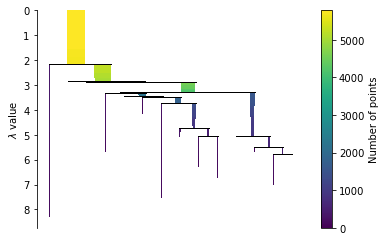

In [144]:
clusterer.condensed_tree_.plot()

In [145]:
# dataset = dataframe[dataframe['cluster'] != -1]

In [146]:
clusters = {}

for i, sentence in enumerate(sentences):
    cluster_id = labels[i]
    if cluster_id not in clusters:
        clusters[cluster_id] = []
    clusters[cluster_id].append(sentence)
    
clusters['0'][0]

"Introverted Elves \\&amp; Conscientious Gnomes: The Expression of Personality in World of Warcraft | Personality inference can be used for dynamic personalization of content or system customization. In this study, we examined whether and how personality is expressed in Virtual Worlds (VWs). Survey data from 1,040 World of Warcraft players containing demographic and personality variables was paired with their VW behavioral metrics over a four-month period. Many behavioral cues in VWs were found to be related to personality. For example, Extraverts prefer group activities over solo activities. We also found that these behavioral indicators can be used to infer a player's personality."

In [147]:
stopwords = open('./data/stopwords.txt').readlines()
stopwords = [word.replace('\n', '') for word in stopwords]

filtered = []

for sentence in sentences:
    sentence = sentence.lower().split(' ')
    sentence = [word for word in sentence if word not in stopwords]
    filtered.append(' '.join(sentence))

filtered[:10]

["feminist hci methodology: social science, feminism, hci | substantial efforts ubiquitous computing, ict4d, sustainable interaction design, others, hci increasingly engaging matters social change qualities interaction. so, hci takes scientific moral concerns. paper explores potential feminist social science contribute benefit hci's rising interest social change. describes feminist contributions debates philosophy science helped clarify relationships objectivity, values, data collection interpretation, social consequences. feminists proposed implemented strategies pursue scientific moral agendas equal rigor. paper, assess epistemologies, methodologies, methods feminist social science relative prior ongoing efforts hci. conclude proposing outline feminist hci methodology.",
 '| "out there" increasingly topic concern hci. clarion calls, researchers field turning attention technology-mediated activities shaped euro-american sensibilities defined culturally geographically distinct. fieldwo

In [148]:
from sklearn.feature_extraction.text import CountVectorizer
from ctfidf import CTFIDFVectorizer
from nltk.stem.lancaster import LancasterStemmer

stemmer = LancasterStemmer()

docs = pd.DataFrame({'Document': filtered, 'Class': labels})
docs_per_class = docs.groupby(['Class'], as_index=False).agg({'Document': ' '.join})

# Create bag of words
count_vectorizer = CountVectorizer().fit(docs_per_class.Document)
count = count_vectorizer.transform(docs_per_class.Document)
words = count_vectorizer.get_feature_names()

# Extract top 10 words
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs)).toarray()

cluster_keywords = {}
deduplicate = {}
stop = ['based']
label_index = [label for label in docs_per_class.Class]
for label in docs_per_class.Class:
    cluster_keywords[label] = []
    deduplicate[label] = set()
    
    indices = ctfidf[label_index.index(label)].argsort().tolist()
    indices.reverse()
    for index in indices:
        if stemmer.stem(words[index]) not in deduplicate[label] and words[index] not in stop:
            deduplicate[label].add(stemmer.stem(words[index]))
            cluster_keywords[label].append(words[index])
            if len(cluster_keywords[label]) == 6:
                break
    cluster_keywords[label] = ', '.join(cluster_keywords[label])
cluster_keywords

/Users/shauna/.miniforge3/envs/chi-ten-years/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



{'-1': 'design, study, data, users, social, work',
 '0': 'game, players, design, experience, study, social',
 '1': 'sound, speech, voice, audio, music, user',
 '10': 'social, media, users, ai, online, news',
 '2': 'mobile, stress, time, users, smartphone, work',
 '3': 'user, touch, interaction, input, virtual, 3d',
 '4': 'health, support, self, care, patients, social',
 '5': 'blind, reading, people, accessibility, visual, users',
 '6': 'children, design, play, parents, autism, families',
 '7': 'data, visualization, code, design, user, programming',
 '8': 'hci, design, community, technology, paper, social',
 '9': 'privacy, security, users, authentication, passwords, data'}

## Step 5: Visualization of results

In [88]:
import plotly.express as px
from sklearn.manifold import TSNE

# reducer = UMAP()

# coords = reducer.fit_transform(reduced).transpose()  # Create a 2-D version for visualization

coords = TSNE().fit_transform(reduced).transpose()

/Users/shauna/.miniforge3/envs/chi-ten-years/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/shauna/.miniforge3/envs/chi-ten-years/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [218]:
titles = [
    sentence.split('|')[0] for sentence in sentences
]

keywords = [
    cluster_keywords[labels[i]] for i, _ in enumerate(sentences)
]


dataframe = pd.DataFrame({
    'text': titles, 
    'x': coords[0], 
    'y': coords[1], 
    'Clusters': keywords, 
    'keywords': keywords,
    'year': years,
})

fig = px.scatter(dataframe, x='x', y='y', hover_name='text',
                 hover_data={'keywords': True, 'Clusters': False, 'year': True, 'x': False, 'y': False},
                 color_discrete_sequence=px.colors.qualitative.Pastel,
                 color='Clusters')
fig["layout"].pop("updatemenus")
fig.update_layout(annotations=[
    {
        "xref": "paper","yref": "paper",
        "align": "left",
        "x":1.02, "y":0,
        'xanchor': 'left',
        "text": '''
            <b>如何理解这张图表?</b> <br>
            1. 距离越近的点说明标题和摘要内容越相似，距离远的反之； <br>
            2. 上面的规则适用于任意两点，不局限于类内部； <br>
            3. 彼此相像、和其余内容不像的论文会被算作一个类； <br>
            5. 关键词是那些对本类来说最独特、又出现次数多的词； <br>
            6. 类内部还会有更小的类，肉眼就能看出； <br>
            7. 类之间重叠的部分可能有分类模糊、彼此相似的论文； <br>
            8. 接上条，可以关注关键词首位是design的那个类如何与多个类有重叠。 <br><br>
            
            <b>怎么做的?</b> <br>
            1. 从BibTeX中取出标题和摘要拼在一起； <br>
            2. 用SentenceTransformer将其转换为向量（一组数字）用来表示内容； <br>
            3. 用UMAP算法将200维的向量降到5维，方便聚类。计算采用余弦相似度； <br>
            4. 使用HDBSCAN算法自动发现聚类方式，最小的类大小设为120篇文章； <br>
            5. 使用class-TFIDF计算出每类中最具有代表性的关键词； <br>
            6. 用tSNE算法把数据进一步降到二维，再使用Plotly生成交互式可视化。
        ''', 
        "showarrow":False
    },
])
fig.write_html("./15clusters.html")
fig.show()